In [1]:
import pandas as pd
import numpy as np
import ast

In [2]:
file_path = 'UoB_Set01_2025-05-16LOBs.txt'

In [3]:
# Parsing single-line text
def parse_line_corrected(line):
    line = line.replace('Exch0', "'Exch0'")
    data = ast.literal_eval(line)
    return {
        'timestamp': data[0],
        'exchange': data[1],
        'bids': data[2][0][1],
        'asks': data[2][1][1]
    }

In [4]:
# Parses incoming text line by line
parsed_data_corrected = []
with open(file_path, 'r') as file:
    for line in file:
        parsed_data_corrected.append(parse_line_corrected(line))

In [5]:
df_corrected = pd.DataFrame(parsed_data_corrected)

In [6]:
df_corrected = df_corrected[['exchange', 'timestamp', 'bids', 'asks']]
df_corrected.head()

,exchange,timestamp,bids,asks
0,Exch0,0.000,[],[]
1,Exch0,2.294,[],"[[158, 5]]"
2,Exch0,2.604,"[[1, 9]]","[[158, 5]]"
3,Exch0,3.317,"[[2, 9]]","[[158, 5]]"
4,Exch0,3.968,"[[3, 4], [2, 9]]","[[158, 5]]"


In [7]:
# Sort bids and asks and take the top two
def process_row(row):
    bids_sorted = sorted(row['bids'], key=lambda x: x[0], reverse=True)[:2] if row['bids'] else []
    asks_sorted = sorted(row['asks'], key=lambda x: x[0])[:2] if row['asks'] else []
    return bids_sorted, asks_sorted

In [8]:
df_corrected[['bids', 'asks']] = df_corrected.apply(lambda row: process_row(row), axis=1, result_type='expand')
df_filtered = (df_corrected[(df_corrected['bids'].apply(len) >= 2) & (df_corrected['asks'].apply(len) >= 2)]).reset_index(drop=True)
df_filtered.head()

,exchange,timestamp,bids,asks
0,Exch0,4.309,"[[4, 4], [2, 9]]","[[158, 5], [532, 1]]"
1,Exch0,4.433,"[[5, 9], [4, 4]]","[[158, 5], [532, 1]]"
2,Exch0,4.557,"[[5, 9], [4, 4]]","[[157, 3], [158, 5]]"
3,Exch0,4.743,"[[142, 1], [5, 9]]","[[157, 3], [158, 5]]"
4,Exch0,4.805,"[[142, 1], [5, 9]]","[[157, 3], [158, 5]]"


In [9]:
def remove_max_bid_outliers(bids, mean_price, std_price, threshold=3):
    if not bids:
        return True  
    # Calculate z-score for the maximum bid price
    max_bid_price = max(bid[0] for bid in bids)
    z_score = abs(max_bid_price - mean_price) / std_price
    
    # Return True if the z-score is within the threshold, indicating it's not an outlier
    return z_score <= threshold

# Calculate the mean and standard deviation for the maximum bid prices
max_bid_prices = [max(bid[0] for bid in bids_list) for bids_list in df_filtered['bids'] if bids_list]
mean_max_price = np.mean(max_bid_prices)
std_max_price = np.std(max_bid_prices)

# Filter the DataFrame rows
df_filtered_no_max_outliers = df_filtered[df_filtered['bids'].apply(
    lambda bids: remove_max_bid_outliers(bids, mean_max_price, std_max_price, 3)
)]

# Reset the index after the filter operation
df_filtered_no_max_outliers = df_filtered_no_max_outliers.reset_index(drop=True)

df_filtered_no_max_outliers

,exchange,timestamp,bids,asks
0,Exch0,4.743,"[[142, 1], [5, 9]]","[[157, 3], [158, 5]]"
1,Exch0,4.805,"[[142, 1], [5, 9]]","[[157, 3], [158, 5]]"
2,Exch0,4.836,"[[142, 1], [5, 9]]","[[156, 3], [158, 5]]"
3,Exch0,5.456,"[[127, 1], [81, 1]]","[[135, 1], [155, 3]]"
4,Exch0,5.487,"[[127, 1], [81, 1]]","[[134, 3], [135, 1]]"
...,...,...,...,...
317338,Exch0,30599.542,"[[132, 5], [131, 2]]","[[141, 1], [142, 1]]"
317339,Exch0,30599.790,"[[132, 5], [131, 2]]","[[141, 1], [142, 1]]"
317340,Exch0,30599.821,"[[132, 5], [131, 2]]","[[141, 1], [142, 1]]"
317341,Exch0,30599.945,"[[132, 5], [131, 2]]","[[141, 1], [444, 5]]"


In [10]:
def remove_min_bid_outliers(bids, mean_min_price, std_min_price, threshold=3):
    if not bids:
        return True
    min_bid_price = min(bid[0] for bid in bids)
    z_score = (min_bid_price - mean_min_price) / std_min_price
    return abs(z_score) <= threshold

# Calculate mean and standard deviation for the minimum bid prices across the DataFrame
min_bid_prices = [min(bid[0] for bid in bids_list) for bids_list in df_filtered_no_max_outliers['bids'] if bids_list]
mean_min_price = np.mean(min_bid_prices)
std_min_price = np.std(min_bid_prices)

# Apply the outlier removal function to each row
df_filtered_no_min_outliers = df_filtered_no_max_outliers[df_filtered_no_max_outliers['bids'].apply(
    lambda bids: remove_min_bid_outliers(bids, mean_min_price, std_min_price, 3)
)]

# Reset index
df_filtered_no_min_outliers.reset_index(drop=True, inplace=True)

# Display the first few rows
df_filtered_no_min_outliers

,exchange,timestamp,bids,asks
0,Exch0,5.611,"[[128, 4], [127, 1]]","[[134, 3], [135, 1]]"
1,Exch0,6.851,"[[129, 4], [128, 1]]","[[130, 3], [132, 1]]"
2,Exch0,6.882,"[[129, 4], [128, 1]]","[[130, 3], [132, 1]]"
3,Exch0,6.944,"[[129, 1], [128, 1]]","[[132, 1], [134, 3]]"
4,Exch0,7.161,"[[129, 1], [128, 1]]","[[132, 5], [134, 3]]"
...,...,...,...,...
308497,Exch0,30599.542,"[[132, 5], [131, 2]]","[[141, 1], [142, 1]]"
308498,Exch0,30599.790,"[[132, 5], [131, 2]]","[[141, 1], [142, 1]]"
308499,Exch0,30599.821,"[[132, 5], [131, 2]]","[[141, 1], [142, 1]]"
308500,Exch0,30599.945,"[[132, 5], [131, 2]]","[[141, 1], [444, 5]]"


In [11]:
def remove_min_ask_outliers(asks, mean_price, std_price, threshold=3):
    if not asks:
        return True  # Keep rows with no asks as they're not outliers
    min_ask_price = min(ask[0] for ask in asks)
    z_score = (min_ask_price - mean_price) / std_price
    return abs(z_score) <= threshold

# Calculate mean and standard deviation for minimum ask prices
min_ask_prices = [min(ask[0] for ask in asks_list) for asks_list in df_filtered['asks'] if asks_list]
mean_min_ask_price = np.mean(min_ask_prices)
std_min_ask_price = np.std(min_ask_prices)

# Apply the function to filter rows based on minimum ask price outliers
df_filtered_no_min_ask_outliers = df_filtered_no_min_outliers[df_filtered_no_min_outliers['asks'].apply(
    lambda asks: remove_min_ask_outliers(asks, mean_min_ask_price, std_min_ask_price, 3)
)]

# Reset the index after filtering
df_filtered_no_min_ask_outliers.reset_index(drop=True, inplace=True)

df_filtered_no_min_ask_outliers

,exchange,timestamp,bids,asks
0,Exch0,5.611,"[[128, 4], [127, 1]]","[[134, 3], [135, 1]]"
1,Exch0,6.851,"[[129, 4], [128, 1]]","[[130, 3], [132, 1]]"
2,Exch0,6.882,"[[129, 4], [128, 1]]","[[130, 3], [132, 1]]"
3,Exch0,6.944,"[[129, 1], [128, 1]]","[[132, 1], [134, 3]]"
4,Exch0,7.161,"[[129, 1], [128, 1]]","[[132, 5], [134, 3]]"
...,...,...,...,...
300088,Exch0,30599.542,"[[132, 5], [131, 2]]","[[141, 1], [142, 1]]"
300089,Exch0,30599.790,"[[132, 5], [131, 2]]","[[141, 1], [142, 1]]"
300090,Exch0,30599.821,"[[132, 5], [131, 2]]","[[141, 1], [142, 1]]"
300091,Exch0,30599.945,"[[132, 5], [131, 2]]","[[141, 1], [444, 5]]"


In [12]:
def remove_max_ask_outlier(asks, mean_price, std_price, threshold=3):
    if not asks:
        return True
    max_ask_price = max(ask[0] for ask in asks)
    z_score = (max_ask_price - mean_price) / std_price
    return abs(z_score) <= threshold

# Calculate mean and standard deviation for maximum ask prices
max_ask_prices = [max(ask[0] for ask in asks_list) for asks_list in df_filtered_no_min_ask_outliers['asks'] if asks_list]
mean_max_ask_price = np.mean(max_ask_prices)
std_max_ask_price = np.std(max_ask_prices)

# Apply the function to filter rows based on maximum ask price outliers
df_filtered_no_max_ask_outliers = df_filtered_no_min_ask_outliers[df_filtered_no_min_ask_outliers['asks'].apply(
    lambda asks: remove_max_ask_outlier(asks, mean_max_ask_price, std_max_ask_price, 3)
)]

# Reset the index after filtering
df_filtered_no_max_ask_outliers.reset_index(drop=True, inplace=True)

df_filtered_no_max_ask_outliers

,exchange,timestamp,bids,asks
0,Exch0,5.611,"[[128, 4], [127, 1]]","[[134, 3], [135, 1]]"
1,Exch0,6.851,"[[129, 4], [128, 1]]","[[130, 3], [132, 1]]"
2,Exch0,6.882,"[[129, 4], [128, 1]]","[[130, 3], [132, 1]]"
3,Exch0,6.944,"[[129, 1], [128, 1]]","[[132, 1], [134, 3]]"
4,Exch0,7.161,"[[129, 1], [128, 1]]","[[132, 5], [134, 3]]"
...,...,...,...,...
294447,Exch0,30599.542,"[[132, 5], [131, 2]]","[[141, 1], [142, 1]]"
294448,Exch0,30599.790,"[[132, 5], [131, 2]]","[[141, 1], [142, 1]]"
294449,Exch0,30599.821,"[[132, 5], [131, 2]]","[[141, 1], [142, 1]]"
294450,Exch0,30599.945,"[[132, 5], [131, 2]]","[[141, 1], [444, 5]]"


In [13]:
def split_bids_asks(row):
    # Splitting bids into prices and sizes
    bid_price1, bid_size1 = row['bids'][0]
    bid_price2, bid_size2 = row['bids'][1]
    ask_price1, ask_size1 = row['asks'][0]
    ask_price2, ask_size2 = row['asks'][1]  
    return pd.Series([bid_price1, bid_price2, bid_size1, bid_size2, ask_price1, ask_price2, ask_size1, ask_size2])

# Apply the function to each row of the DataFrame and create new columns
df_final_filtered = df_filtered_no_max_ask_outliers.copy()
df_final_filtered[['bid_price1', 'bid_price2', 'bid_size1', 'bid_size2', 'ask_price1', 'ask_price2', 'ask_size1', 'ask_size2']] = df_final_filtered.apply(split_bids_asks, axis=1)
df_final_filtered.drop(['bids', 'asks'], axis=1, inplace=True)

# Display the first few rows of the DataFrame to verify the changes
df_final_filtered

,exchange,timestamp,bid_price1,bid_price2,bid_size1,bid_size2,ask_price1,ask_price2,ask_size1,ask_size2
0,Exch0,5.611,128,127,4,1,134,135,3,1
1,Exch0,6.851,129,128,4,1,130,132,3,1
2,Exch0,6.882,129,128,4,1,130,132,3,1
3,Exch0,6.944,129,128,1,1,132,134,1,3
4,Exch0,7.161,129,128,1,1,132,134,5,3
...,...,...,...,...,...,...,...,...,...,...
294447,Exch0,30599.542,132,131,5,2,141,142,1,1
294448,Exch0,30599.790,132,131,5,2,141,142,1,1
294449,Exch0,30599.821,132,131,5,2,141,142,1,1
294450,Exch0,30599.945,132,131,5,2,141,444,1,5


In [14]:
# Convert 'timestamp' to a datetime index (assuming timestamps are already in a proper format or sequence)
df_final_filtered['timestamp'] = pd.to_datetime(df_final_filtered['timestamp'], unit='s')
df_final_filtered.set_index('timestamp', inplace=True)
df_final_filtered.index = df_final_filtered.index.to_period('S')

In [15]:
df_final_filtered

,exchange,bid_price1,bid_price2,bid_size1,bid_size2,ask_price1,ask_price2,ask_size1,ask_size2
timestamp,,,,,,,,,
1970-01-01 00:00:05,Exch0,128,127,4,1,134,135,3,1
1970-01-01 00:00:06,Exch0,129,128,4,1,130,132,3,1
1970-01-01 00:00:06,Exch0,129,128,4,1,130,132,3,1
1970-01-01 00:00:06,Exch0,129,128,1,1,132,134,1,3
1970-01-01 00:00:07,Exch0,129,128,1,1,132,134,5,3
...,...,...,...,...,...,...,...,...,...
1970-01-01 08:29:59,Exch0,132,131,5,2,141,142,1,1
1970-01-01 08:29:59,Exch0,132,131,5,2,141,142,1,1
1970-01-01 08:29:59,Exch0,132,131,5,2,141,142,1,1


In [16]:
from statsmodels.tsa.stattools import adfuller

# Extract the 'lowest_ask' column for stationarity testing
highest_bid_series = df_final_filtered['bid_price1']

# Perform Augmented Dickey-Fuller test
result = adfuller(highest_bid_series.dropna(), autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# Using Critical Values for decision
is_stationary = True
for key, value in result[4].items():
    if result[0] > value:
        is_stationary = False
        break

if is_stationary:
    print("The series is stationary based on critical values.")
else:
    print("The series is not stationary based on critical values.")

ADF Statistic: -35.323762
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
The series is stationary based on critical values.


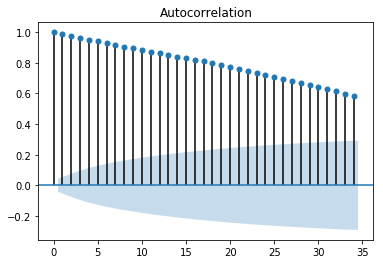

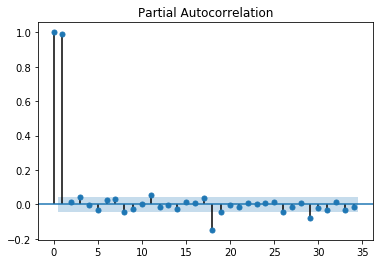

In [18]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Selecting the first 2000 rows
data_subset = df_final_filtered['bid_price1'].iloc[:2000]

# Plot ACF and PACF for the subset
plot_acf(data_subset)
plot_pacf(data_subset)
plt.show()

In [32]:
import pmdarima as pm

# Assuming you have your time series data in 'lowest_ask_series'
# auto_arima scans various combinations of p, d, and q to find the best ARIMA model
best_model = pm.auto_arima(data_subset, seasonal=False, stepwise=True,
                           suppress_warnings=True, D=1, max_p=5, max_q=5, max_d=2,
                           error_action='ignore', trace=True)

print(f"Best ARIMA order: {best_model.order}")
print(f"Best seasonal order: {best_model.seasonal_order}")

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4373.401, Time=1.45 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4382.079, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4383.894, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4383.873, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4380.217, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4383.180, Time=0.86 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4382.915, Time=0.18 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4374.497, Time=2.45 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4374.474, Time=1.63 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4383.472, Time=0.95 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4384.680, Time=0.80 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4384.915, Time=0.30 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=4375.658, Time=2.55 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=4371.540, Time=0.60 sec
 ARIMA(1,1,2)(0,0,0)[0]          

In [21]:
# Splitting data into training and test sets
split_point = int(len(data_subset) * 0.8)
train, test = data_subset[:split_point], data_subset[split_point:]

In [35]:
from statsmodels.tsa.arima.model import ARIMA

update_frequency = 5
history = train.copy()
predictions = []
predictions = [None] * len(test)
for t in range(0, len(test), update_frequency):
    # Fit the ARIMA model on the current history
    model = ARIMA(history, order=(2,1,2))
    model_fit = model.fit()
    
    # Make predictions for the next 5 steps
    next_steps_predictions = model_fit.forecast(steps=update_frequency)
    
    # Store the predictions
    if t + update_frequency < len(test):
        predictions[t:t+update_frequency] = next_steps_predictions
    else:
        predictions[t:] = next_steps_predictions[:len(test)-t]
    
    # Update the history with the new observations
    if t + update_frequency < len(test):
        new_history = test[t:t+update_frequency]
        history = pd.concat([history, new_history])
    print(t)
predictions_series = pd.Series(predictions, index=test.index)

0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195
200
205
210
215
220
225
230
235
240
245
250
255
260
265
270
275
280
285
290
295
300
305
310
315
320
325
330
335
340
345
350
355
360
365
370
375
380
385
390
395


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:2062: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:248: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


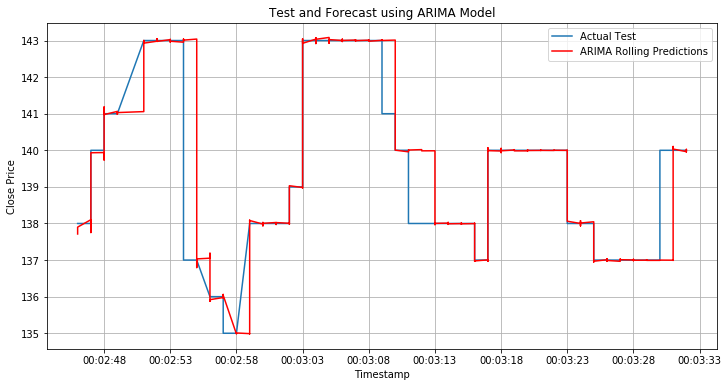

In [36]:
test_datetime_index = test.index.to_timestamp()
predictions_datetime_index = predictions_series.index.to_timestamp()

plt.figure(figsize=(12, 6))
plt.plot(test_datetime_index, test.values, label='Actual Test')
plt.plot(predictions_datetime_index, predictions_series.values, label='ARIMA Rolling Predictions', color='red')
plt.title('Test and Forecast using ARIMA Model')
plt.xlabel('Timestamp')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()